# Computing Project Research Notebook

---
## 1.0: Data Processing

### 1.1: Retrieving Data

In [1]:
%%javascript
//
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import time
import urllib
import datetime
import csv
import matplotlib
import numpy as np
from operator import itemgetter
from datetime import datetime as dt
from matplotlib import pyplot as plt

# https://stackoverflow.com/questions/12433076/download-history-stock-prices-automatically-from-yahoo-finance-in-python
# Gets data for list of tickersm from start date to end date, saves in path.
def get_stocks(tickers, start, end, path):
    
    #Converts a timestring in format 'Y-m-d' UNIX timestamp as a string
    def convert_timestring(time_string):
        return int(time.mktime(dt.strptime(time_string, '%Y-%m-%d').timetuple()))

    #Returns a url for the data between 'start time' and 'end time' for 'ticker'
    def make_url(ticker_symbol, start, end):
        #Convert datetime to UNIX timestamp
        start = convert_timestring(start)
        end = convert_timestring(end)
        url = 'https://query1.finance.yahoo.com/v7/finance/download/'+ ticker_symbol + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history&crumb=jIa1MqK//LA'        
        return url
    
    #Creates fullpath for the file, naming data as the ticke
    def make_filename(ticker, path):
        return path + "/" + ticker + ".csv"
    
    #Gets the data for the specified time and tickers and save them to file
    def pull_historical_data(tickers):
        filename = None
        url = None
        
        for ticker in tickers:
            filename = make_filename(ticker, path)
            url = make_url(ticker, start, end)

            try:
                urllib.request.urlretrieve(url, filename)
            except urllib.request.ContentTooShortError as e:
                outfile = open(filename, "w")
                outfile.write(e.content)
                outfile.close()
            
            print('Written file:' + filename)

    #Exicute code
    pull_historical_data(tickers)

In [2]:
#Loading csv files into pandas returns a dictionary with dataframes of tickers
def load_to_df(tickers, path):
    data = {}
    
    for i in range(len(tickers)):
        full_path = path + "/" + tickers[i] + ".csv"
        ticker = tickers[i].replace('^', '')
        data.update({ticker: pd.read_csv(full_path, parse_dates=True, index_col=0)})
        
    return data

In [3]:
# Downlaoding Files to .csv
path = "C:\\Users\\noahd\\Google Drive\\University\\2k20-21\\Personal Project\\Data\\Stocks"
tickers = ["^GSPC", "^DJI", "^FTSE", "^N225", "^BSESN"]
dates = ('2011-04-07', '2021-04-06')

In [4]:
get_stocks(tickers, dates[0], dates[1], path)
data_raw = load_to_df(tickers, path)

Written file:C:\Users\noahd\Google Drive\University\2k20-21\Personal Project\Data\Stocks/^GSPC.csv
Written file:C:\Users\noahd\Google Drive\University\2k20-21\Personal Project\Data\Stocks/^DJI.csv
Written file:C:\Users\noahd\Google Drive\University\2k20-21\Personal Project\Data\Stocks/^FTSE.csv
Written file:C:\Users\noahd\Google Drive\University\2k20-21\Personal Project\Data\Stocks/^N225.csv
Written file:C:\Users\noahd\Google Drive\University\2k20-21\Personal Project\Data\Stocks/^BSESN.csv


In [5]:
import mplfinance as mpf
from datetime import datetime

#Takes a list of series to plot, attirbutes to plot, and time span
def plot_stock_series(series_dict, start=0, end=-1):
    
    for key, value in series_dict.items():
        mpf.plot(value[start: end], figratio=(9, 3), mav=(20),volume=True,title = key.upper(),tight_layout=True, style="binance",type="ohlc")

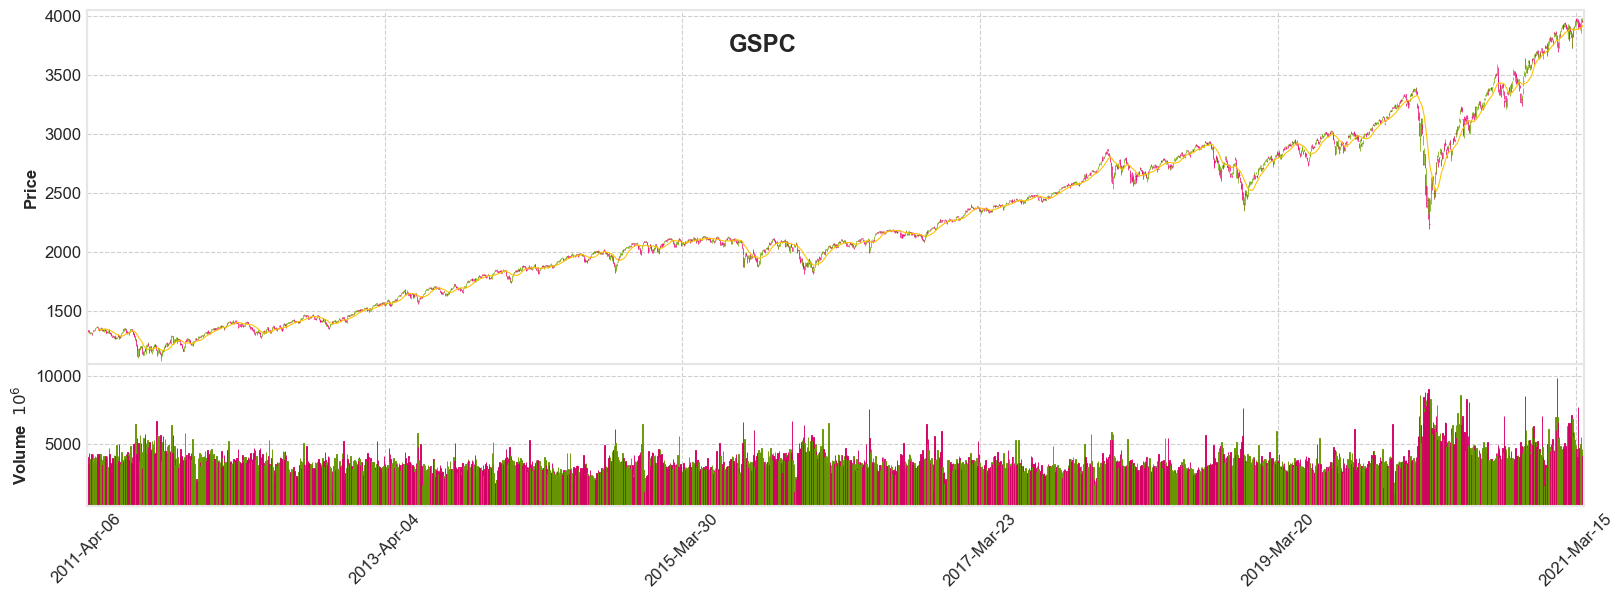

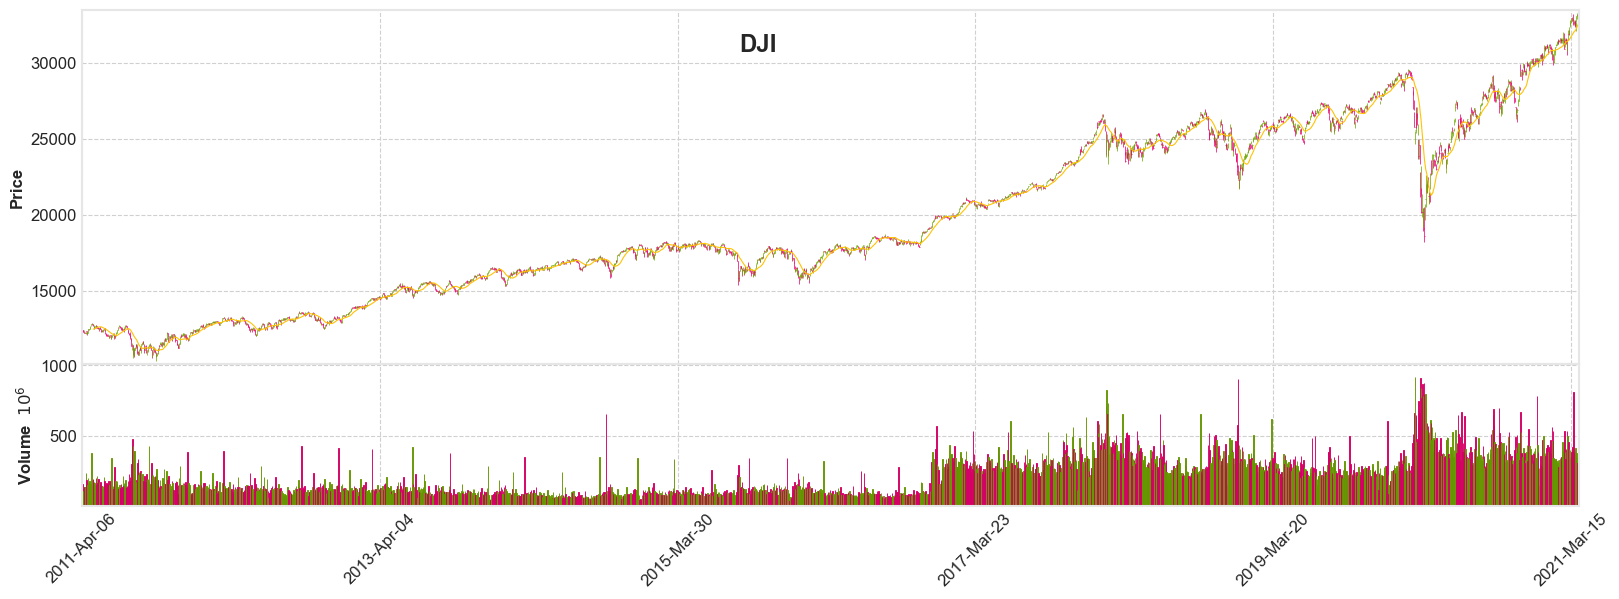

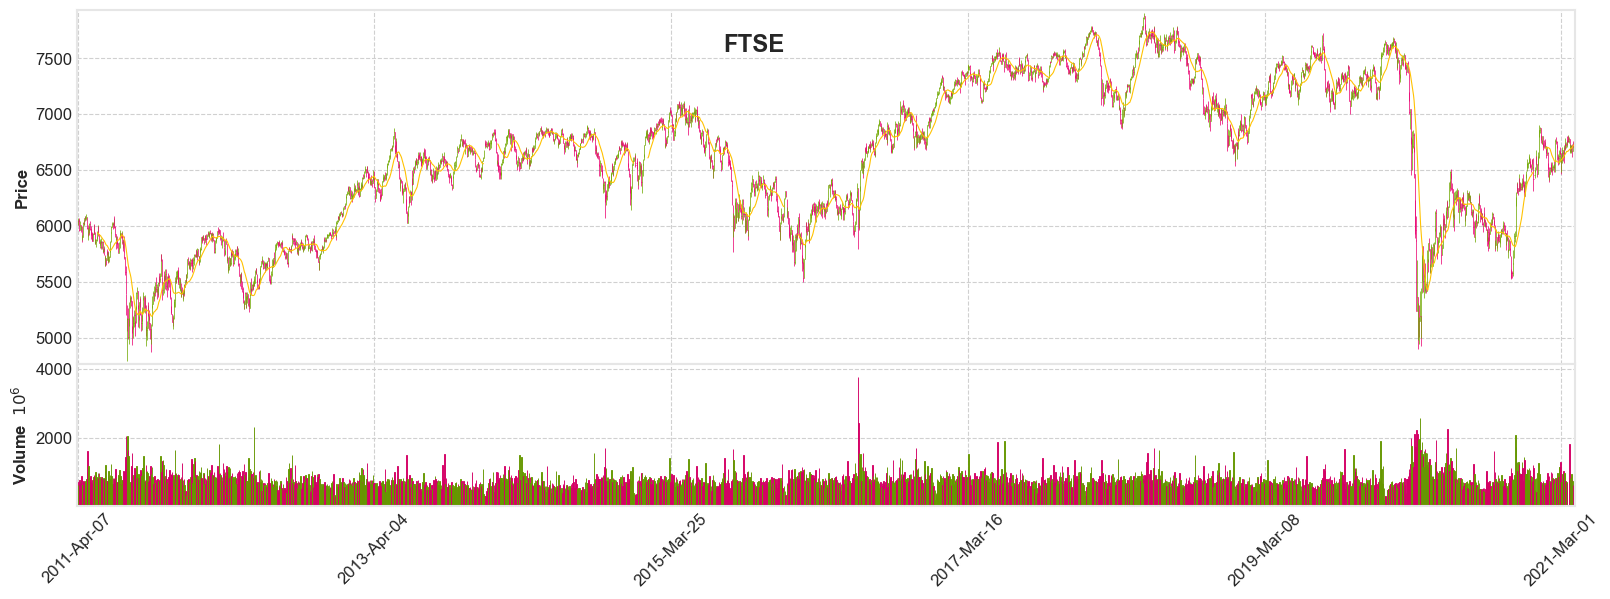

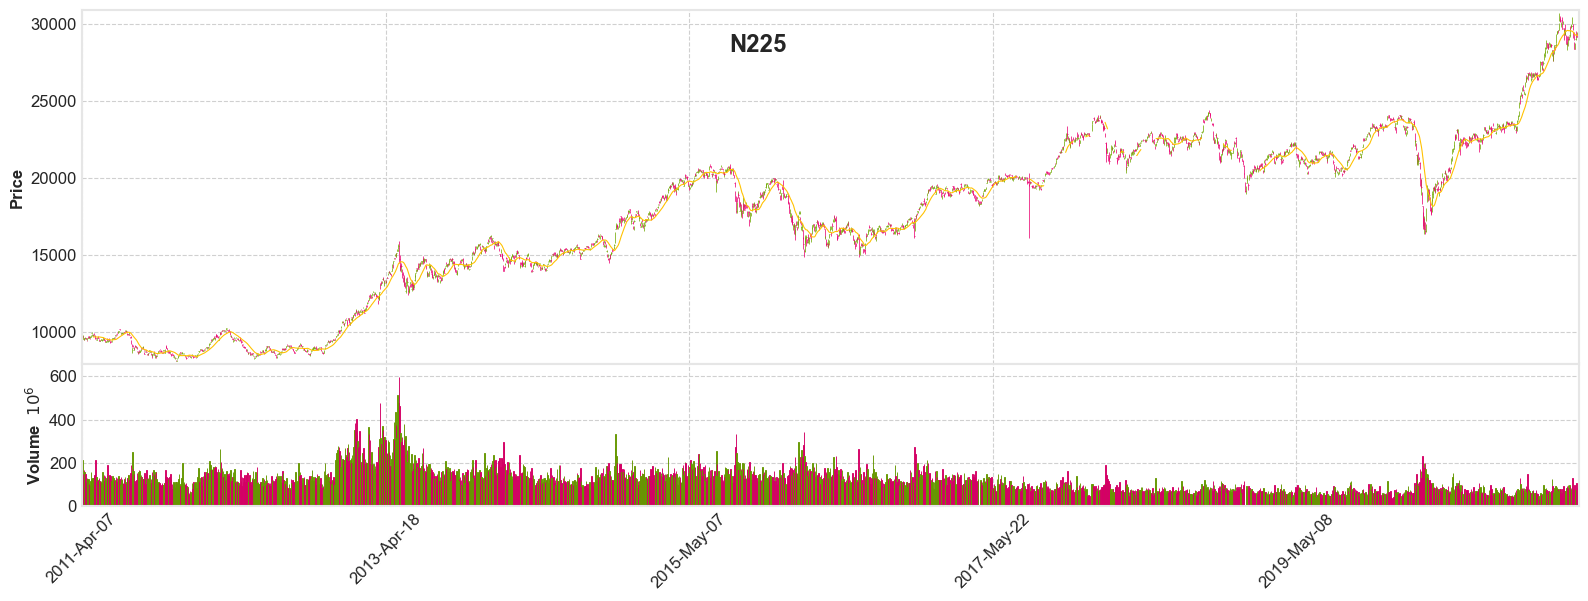

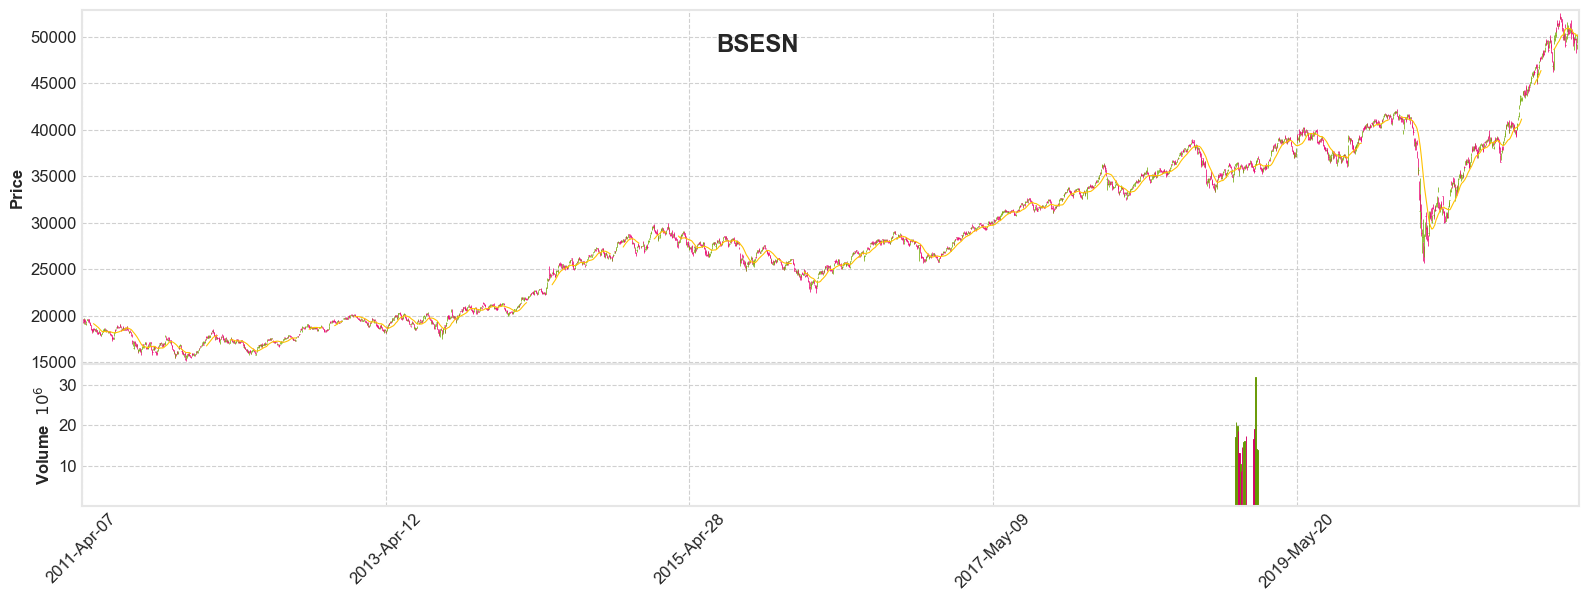

In [6]:
#plotting all data
plot_stock_series(data_raw)

### 1.2: Normalising and Differencing Data

In [7]:
from sklearn import preprocessing

#Applies normalisation and difference transfrom to a pandas dataframe
#Can only normalise and remove Na if passed diff=False
def process_data(data, dates, diff=True):
    data_proc = data.copy()
    scaler = preprocessing.MinMaxScaler()
    
    for key in data_proc:
        df_copy = data_proc[key].copy(deep=True)# So the original data is not overwritten
        df_copy = df_copy.reindex(pd.date_range(start=dates[0], end=dates[1], freq='D')) #For using mutiple time series, all trackers must have the same dates
        
        if diff==True:
            df_copy = df_copy.diff() #Difference transform
        
        df_copy = df_copy.resample('d').mean().interpolate('spline', order=3, s=0) #Iterpolate missing dates
        df_copy = pd.DataFrame(scaler.fit_transform(df_copy.values), columns = df_copy.columns, index=df_copy.index.values) #Scales values
        df_copy = df_copy.drop(df_copy.tail(1).index)
        df_copy = df_copy.dropna(axis=0)
        data_proc[key] = df_copy # Assign new data back to data dictionary    
    
    return data_proc

Depending on the statisical model used, the data might need to be differenced to remove a trend, or only normalised. Datasets of both will be created.

In [8]:
#Processing all Datasets
data_normal = process_data(data_raw, dates, diff=False)
data_diff = process_data(data_raw, dates)

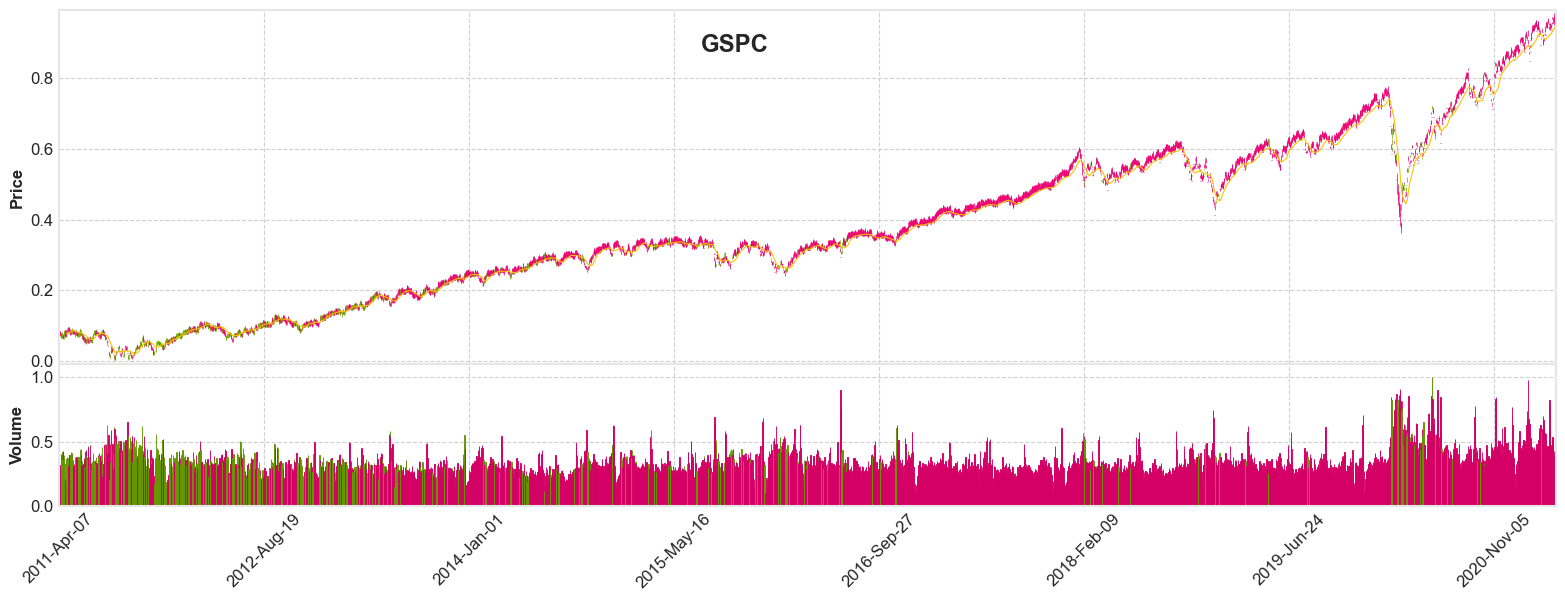

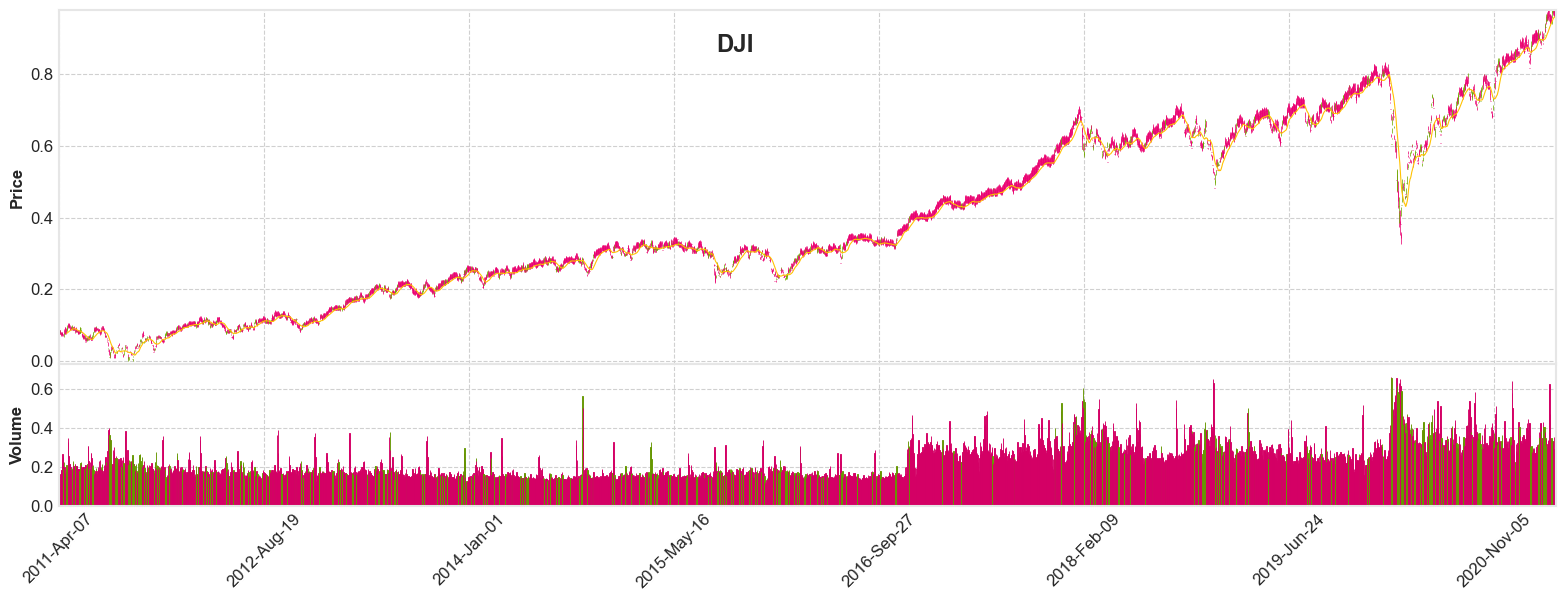

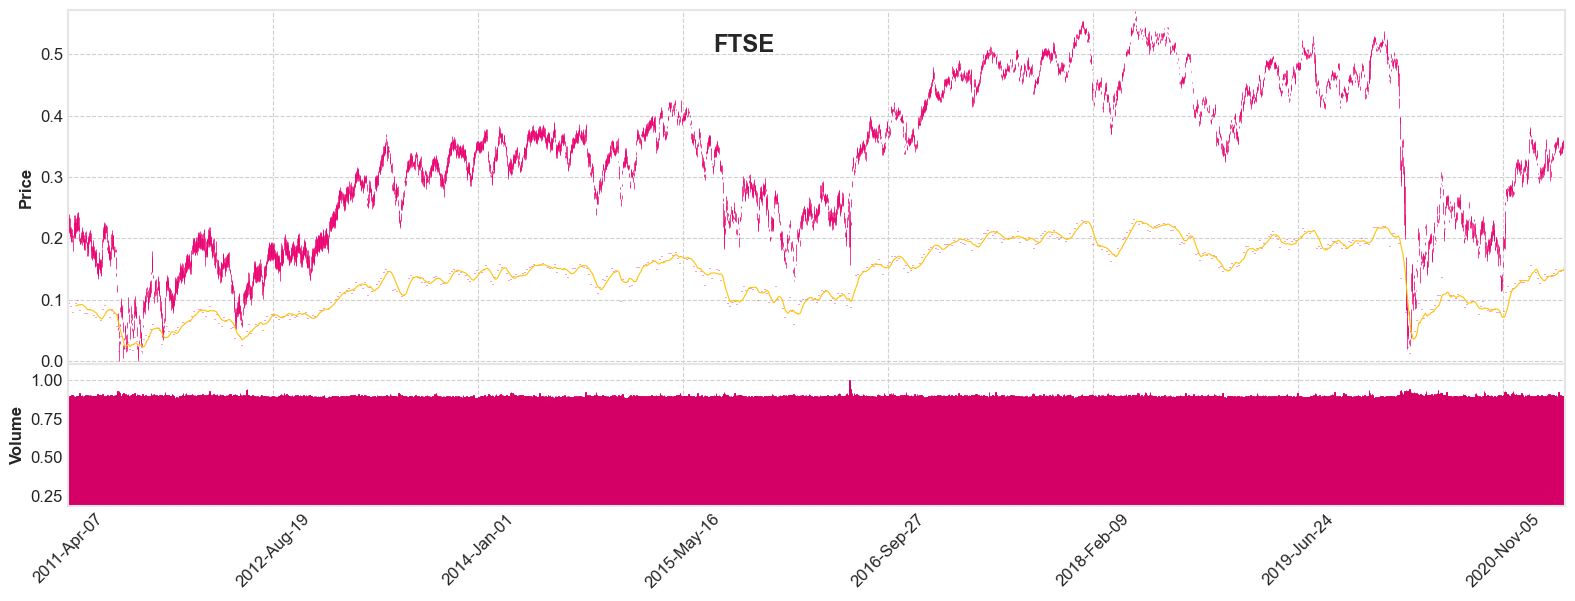

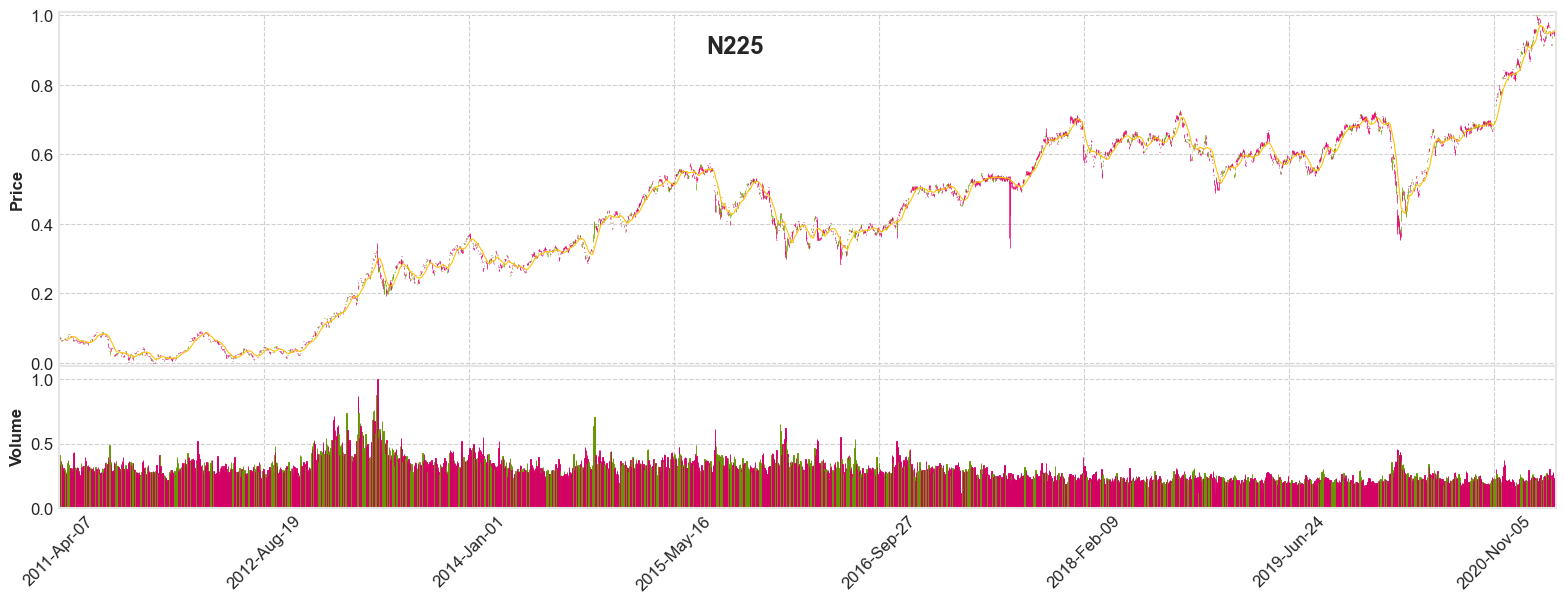

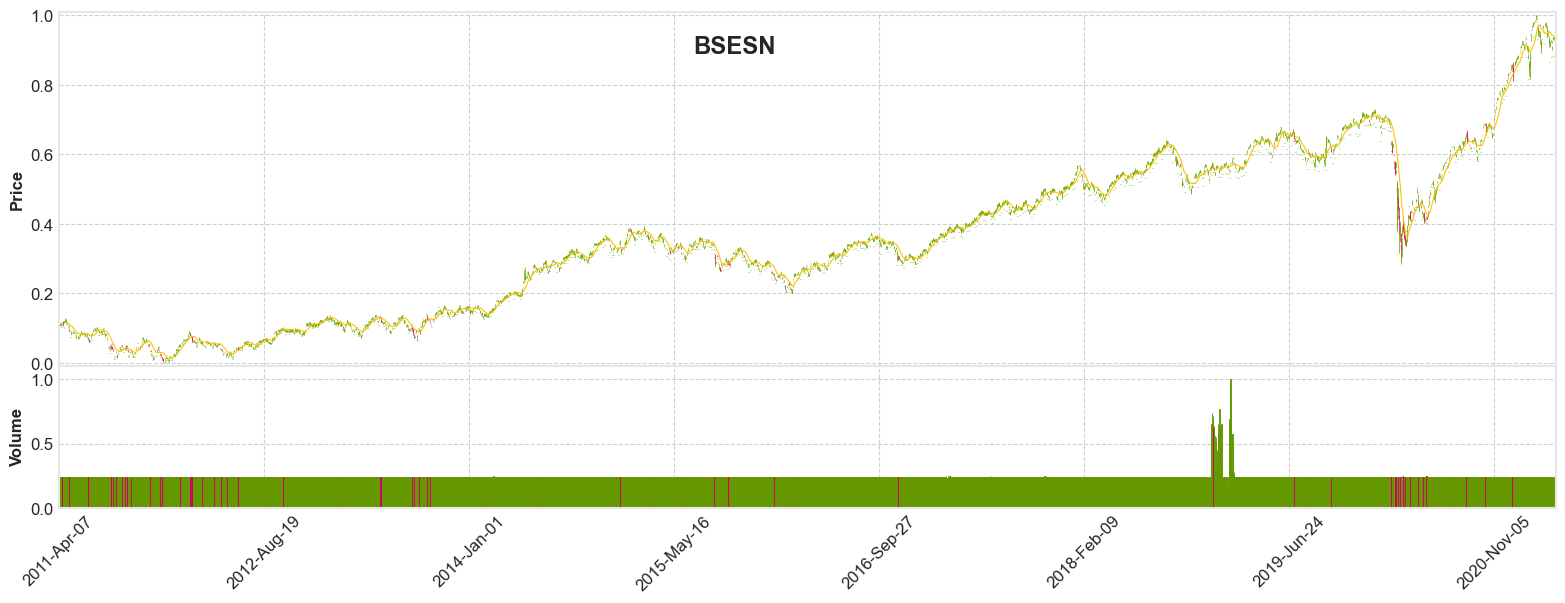

In [9]:
plot_stock_series(data_normal)

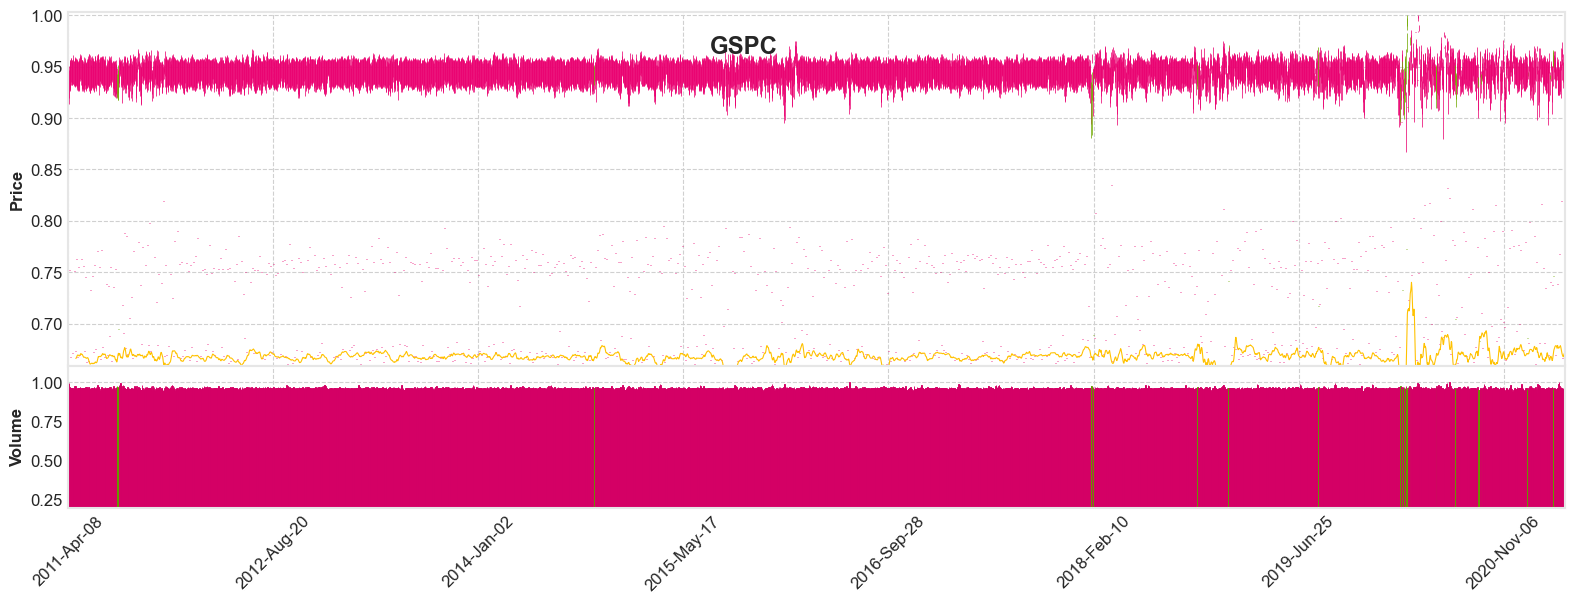

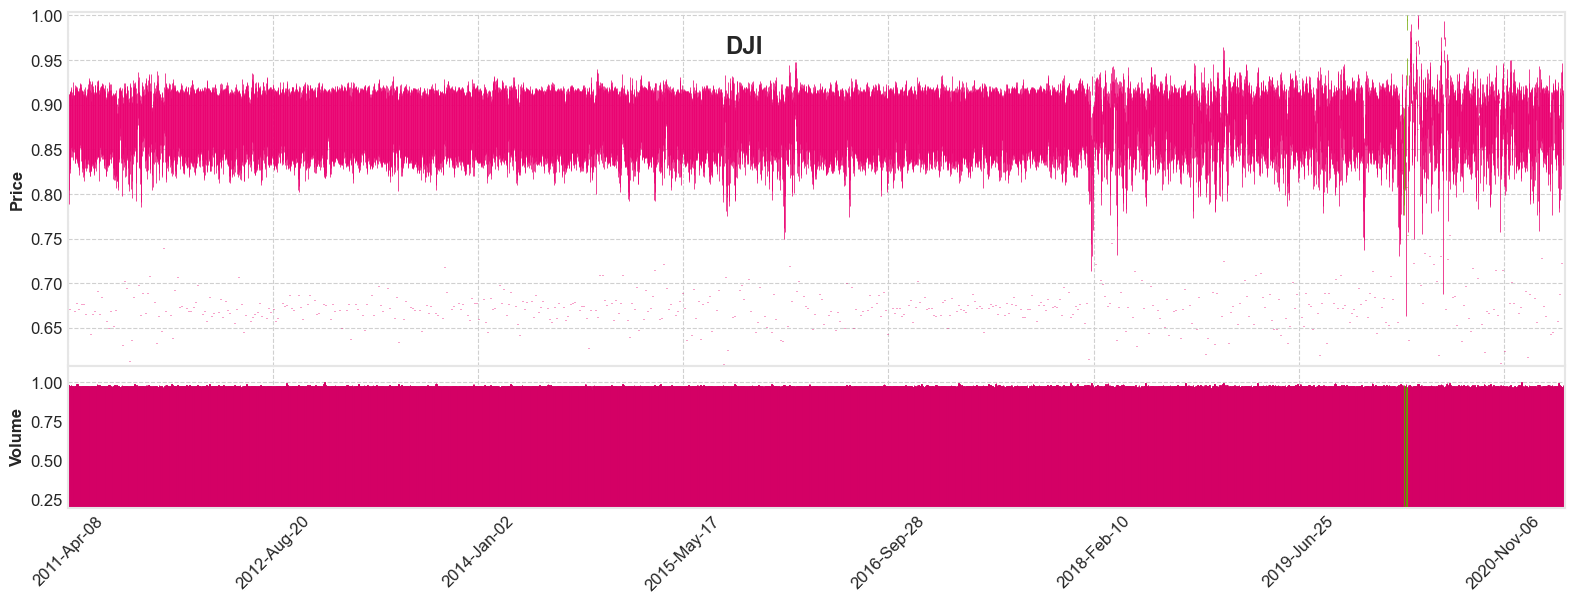

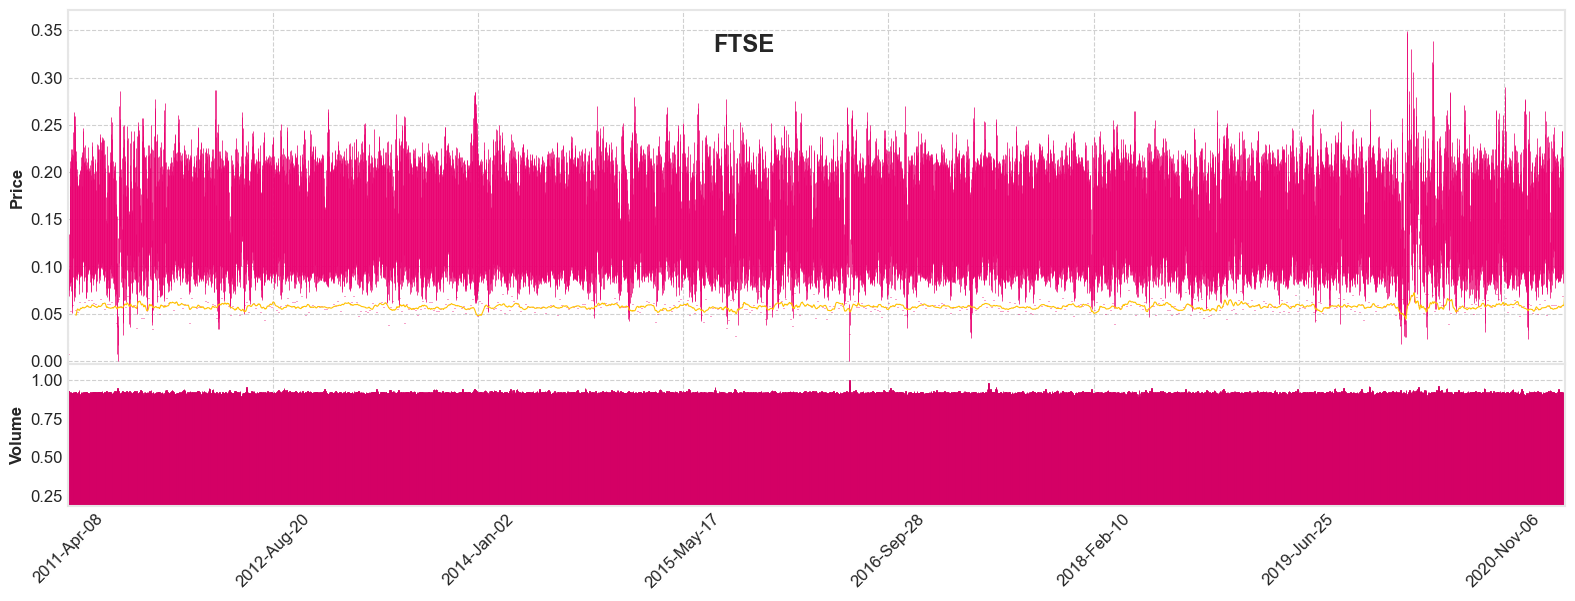

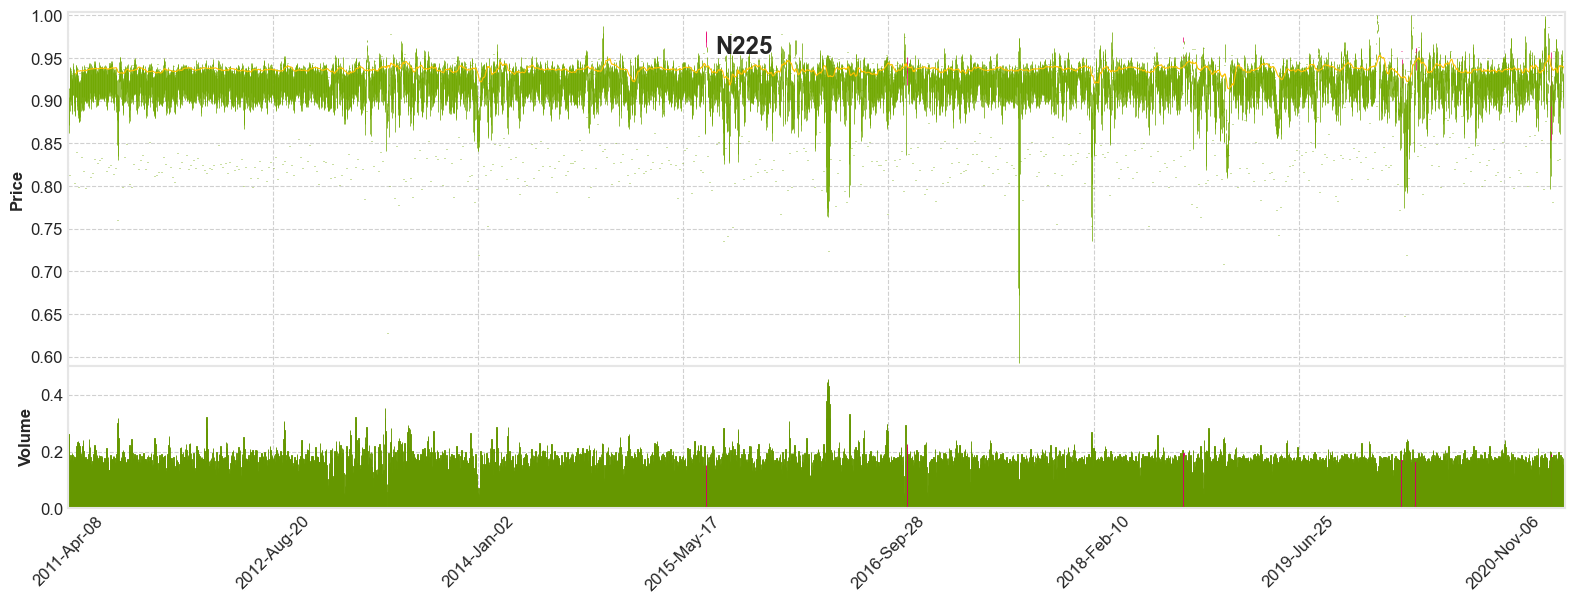

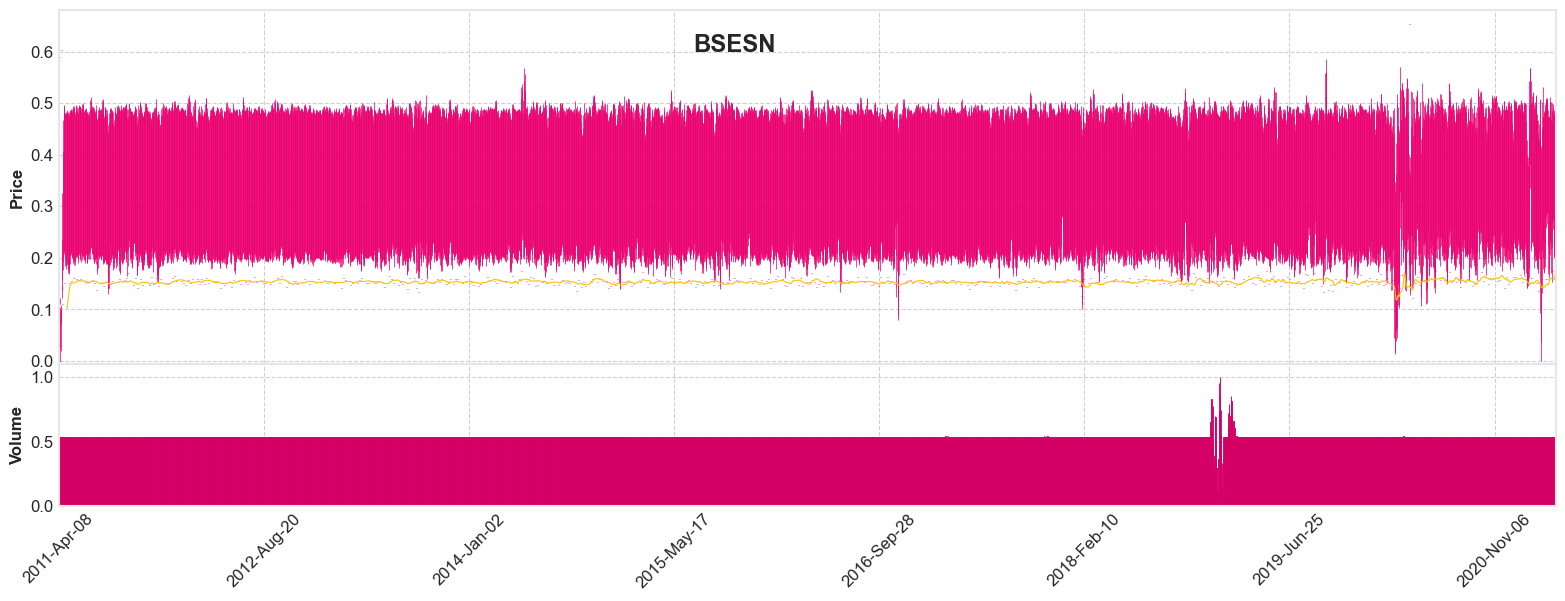

In [10]:
plot_stock_series(data_diff)

### 1.2: Data Exploration
#### 1.21: Seasonal Decomposition

In [11]:
import statsmodels.api as sm

#Decomposes 
def decompose_trend(data, plot=True):
    
    data_decomp = dict.fromkeys(data.keys(),{}) #Initialise dictionary for data decompostion result
    kwargs = {'linewidth': 0.2} #.plot kwargs
    colours = ['black', 'green', 'blue', 'cyan', 'magenta', 'red']
    
    for key, value, in data.items():
        for column in data[key].columns:
            data_decomp[key].update({column: sm.tsa.seasonal_decompose(data[key][column].dropna(),period=365)})
            
        if plot==True:
            fig, axes = plt.subplots(ncols=4, nrows=len(data[key].columns), sharex=True, figsize=(12,5))
            for i, column in enumerate(data_decomp[key]):
                fig.suptitle(key)
                data_decomp[key][column].observed.plot(ax=axes[i][0], **kwargs)
                data_decomp[key][column].trend.plot(ax=axes[i][1], **kwargs)
                data_decomp[key][column].seasonal.plot(ax=axes[i][2], **kwargs)
                data_decomp[key][column].resid.plot(ax=axes[i][3], **kwargs)
                axes[i][0].set_xlabel('Observed', fontsize = 7) # Y label
                axes[i][0].set_ylabel(column, fontsize = 7) # Y label
                axes[i][0].tick_params(axis='both', labelsize=7)
                axes[i][1].tick_params(axis='both', labelsize=7)
                axes[i][2].tick_params(axis='both', labelsize=7)
                axes[i][3].tick_params(axis='both', labelsize=7)
                axes[i][0].get_lines()[0].set_color(colours[i])
                axes[i][1].get_lines()[0].set_color(colours[i])
                axes[i][2].get_lines()[0].set_color(colours[i])
                axes[i][3].get_lines()[0].set_color(colours[i])
                
                
            plt.show()
    
    return data_decomp


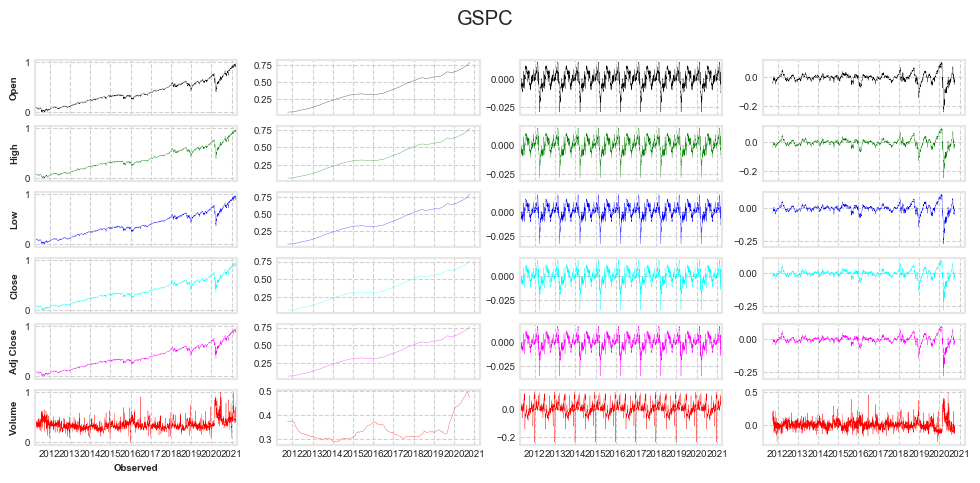

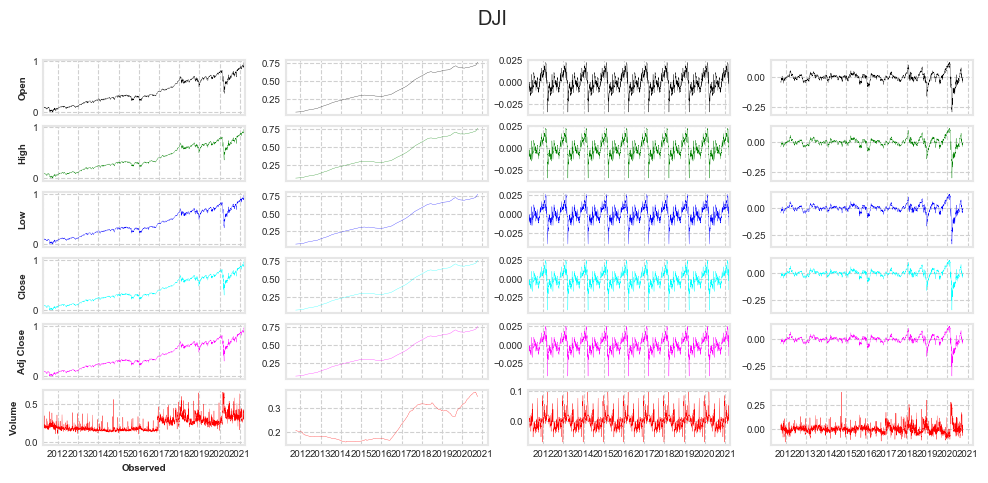

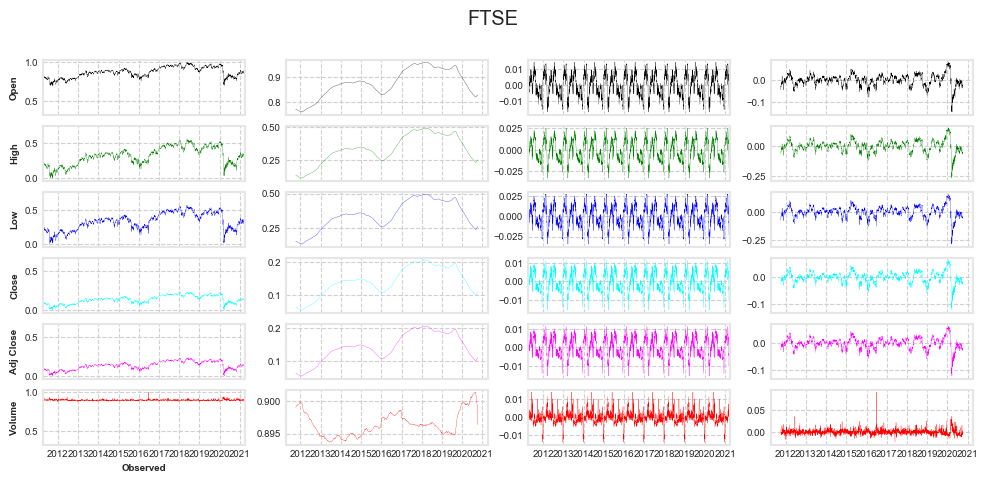

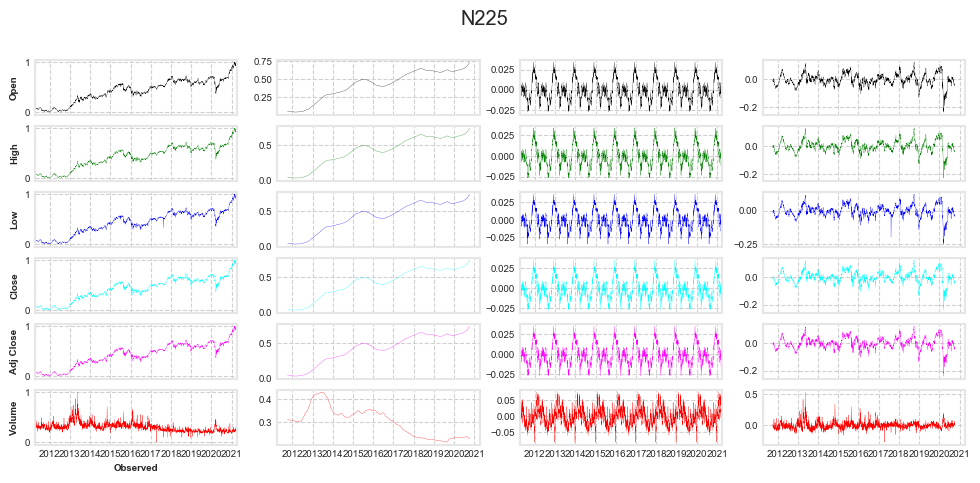

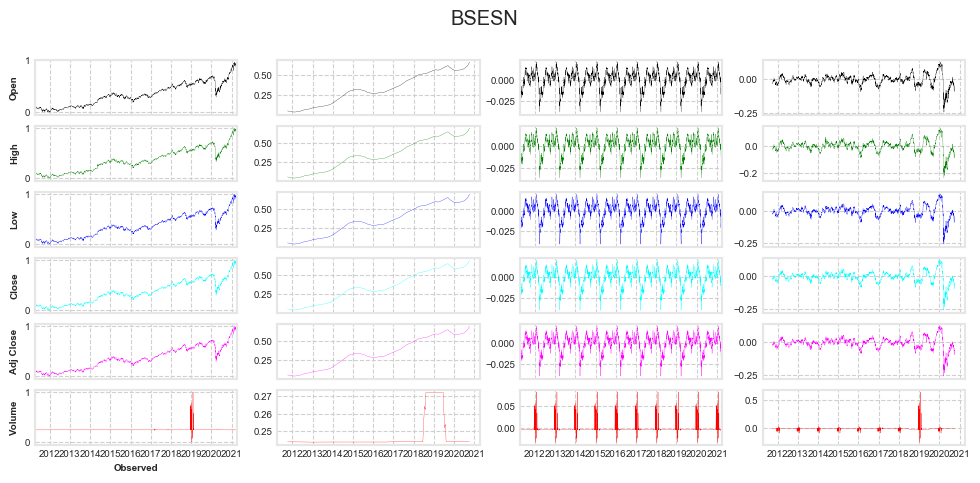

In [12]:
data_decomp = decompose_trend(data_normal)

#### 1.22: Auto Correlation Plot
Auto Correlationplots can help determine information about the type of statistical model best suited.

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def plot_autocorrelation(data):
    
    for key, df in data.items():
        for column in df.columns:
            fig, axes = plt.subplots(1, 2, figsize=(12,3))
            plot_acf(df[column], ax=axes[0], title=key+' '+column+' - Autocorrelation')
            plot_pacf(df[column], ax=axes[1], title=key+' '+column+' - Partial Autocorrelation')
    
    return None

In [14]:
plot_autocorrelation(data_diff)

C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


The all of the data has very weak AC and PAC, with the exception of the volume, which normaly has weak negative correlation in the first few lags. This outcome

#### 2.13: ADF Test
Augmented Dickey–Fuller (ADF) test can be used to determine if a series is stationary or not.

In [15]:
from statsmodels.tsa.stattools import adfuller

#Calculates the ADF results for full dataset orginal and differenced, returns a dataframe with results.
def batch_adf(orginal, diff, significance, start=0, end=-1):
    
    def analyse_res(adf_res, significance):
        if adf_res[0] < significance:
            return True
        
        return False
    
    #contstruct results table with multi index for orginal and diff
    df_index = [[], []]
    
    for i, key in enumerate(orginal.keys()):
        df_index[0].extend([key, key])
        df_index[1].extend(['Orig', 'Diff'])
    
    analysis = pd.DataFrame(index=df_index, columns=orginal[key].columns)
    
    # Get ADF test results and insert to table
    for (key_o, value_o), (key_d, value_d) in zip(orginal.items(), diff.items()):
        for (column_o, column_d) in zip(value_d.columns, value_d.columns):
            analysis.loc[(key_o, 'Orig'), column_o] = analyse_res(adfuller(value_o[column_o], regression='c', autolag='AIC'), significance)
            analysis.loc[(key_d, 'Diff'), column_d] = analyse_res(adfuller(value_d[column_d], regression='c', autolag='AIC'), significance)

    
    return analysis


In [16]:
adf_res_p005 = batch_adf(data_normal, data_diff, 0.05)

##### Table of Results ADF Test; Critical = 0.05
False: ADF p-value higher than critical

True: ADF p-value lower than critical

In [17]:
adf_res_p005

Open   High    Low  Close Adj Close Volume
GSPC  Orig  False  False  False  False     False   True
      Diff   True  False   True   True      True   True
DJI   Orig  False  False   True  False     False   True
      Diff   True   True   True   True      True  False
FTSE  Orig   True   True   True   True      True   True
      Diff   True   True   True   True      True   True
N225  Orig   True   True   True   True      True   True
      Diff   True   True   True   True      True   True
BSESN Orig  False  False   True  False     False   True
      Diff   True   True   True   True      True   True

The test results show that a portion of the un-differenced data has a trend, based on a critical p-value of 0.05. Whist the differenced data had no trend. The mixed results for the undifferenced data having mixed results is suprising for series falling under; Open, High, Low, Close, Adjusted Close, for tickers; FSTE, N255. Since these series had visible upward trends. 

---
## 2:ARIMAX as Baseline

A statisical model will be imployed as a baseline comparison to test a machine learning based model against. For the mdoel VAR (Vector AutoRegression) model will be used. Since the goal of the reaserch is to test a machine learning model using multiple time series in conjuction to forecast.

### 2.1: ARIMAX Configuration
For this test the S&P 500 close series will be used, only half of the data will be used as the dataset is very large. The data will be split into testing and training with a 7:3 train:test split. In the context of this reaserch the model will be used for walk forward prediction

#### Formatting Data

In [ ]:
#Takes data dictionary and creates a 2d numpy array where all time series have the same level
def flatten_dataset(data_dict, n_shifts):
    
    x = []

    for i, df in enumerate(data_dict.values()):
        data = list(list(x) for x in zip(*(df[x].values.tolist() for x in df.columns)))
        x.append(data)

    x = np.asarray(x)
    x  = np.swapaxes(x, 0, 1)
    x = x.reshape(3651, 30)
    y = np.roll(x, n_shifts, axis=0)
    print(x.shape, y.shape)    
    
    return (x, y)

In [ ]:
varmax_x, varmax_y = flatten_dataset(data_diff, -1)

#### Rolling Forecast Implementaion

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning #Ignores warnings
warnings.simplefilter('ignore', ConvergenceWarning)
import copy

# Trains data with rolling forecasting, each sample is predicted based on all previous in chronological order
# order is a tuple with the p, d and q values
def varmax_rolling(train, test, order):
    x = copy.deepcopy(train) # Rolling prediction
    pred = list()
    
    #Rolling forecast
    for row in test:
        model = VARMAX(x, order=order, error_cov_type='diagonal') #Builds the model using the training set and previous test values
        fitted_model = model.fit()
        pred.append(fitted_model.forecast()[0]) #Collects the predicted values for next data point
        x.append(row) #Adds the next data point from test
        print(row)
    
    return pred

In [ ]:
#Testing functions on years worth of data from S&P500/GSPC open value
train, test = train_test_split(varmax_x[0 : 28], test_size=0.3, shuffle=False)
pred = varmax_rolling(train, test, (5, 3))

In [ ]:
#ARIMA results plotting
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import classification_report as clf_report
import matplotlib.patches as mpatches

def plot_varmax_res(y, pred):
    
    #Finds the percentage error for each value
    def p_error(y, pred):
        return pd.Series((abs(pred.values - y.values)/y.values) *100, y.index)
    
    error = p_error(y, pred)
    fig = plt.figure(figsize=(14, 3))
    red_patch = mpatches.Patch(color='red', label='Predicted')
    blue_patch = mpatches.Patch(color='blue', label='True')
    green_patch = mpatches.Patch(color='green', label='Pecentage Error')

    fig.legend(handles=[red_patch, blue_patch, green_patch], ncol=3, loc='upper center')
    ax = y.plot(color="blue")
    pred.plot(ax=ax, color="red")
    ax.set_ylabel('Normalised Value', color='black')
    ax.legend=['Test Data', 'Predicted']
    ax2=ax.twinx()
    error.plot(ax=ax2,color="green",linestyle="--")
    ax2.set_ylabel('Percentage Error', color='green')



### 2.2: ARIMAX Training

### 2.3: ARIMAX Optimisation

#### Grid Search  Tuning
For every combination of (p, d, q), within a difined search space the ARIMA will be run using rolling/walk forward predictions, the MSE between each model will be compared to find the closest fitting model.

In [ ]:
# Takes the data to fit and validate, and an object (search_space) and trails all combinations of ARIMA orders.
# Returns the order of the best fitting model in terms of MSE
def grid_search_ARIMA(series, search_space, test_size=0.3):
    train, test = train_test_split(series, test_size=test_size)
    search_history = []
    
    for p in search_space['p']:
        for d in search_space['d']:
            for q in search_space['q']:
                arima_order = (p, d, q)
                pred = arima_rolling_forecast(train, test, arima_order)
                error = mape(pred, test)
                search_history.append((arima_order, error))
                print('Order: ' + str(arima_order) + '; MAPE: ' + str(error))
    
    search_history = sorted(search_history, key=lambda x:x[1])
    print('Best Order:' + str(search_history[0]))
    #print('Done')
    
    return search_history

In [ ]:
search_space = {'p': list(range(1, 8)),
                'd': list(range(0, 2)),
                'q': list(range(0, 3))}
gs_test = grid_search_ARIMA(data_diff['GSPC']['Close']['2011-04-01':'2011-06-01'], search_space)

In [ ]:
print(gs_test)

### 2.4 ARIMAX Validation

### 2.41 ARIMAX Validation Plenimary Results

---
## 3: Machine Learning Modeling

### 3.1: CNN-LSTM Model Configuration

In [18]:
import keras as kr
import tensorflow as tf
import kerastuner as kt
#Model Layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error as mse




# https://gist.github.com/GermanCM/1943a0dc1eac04f848c6fe9b16947ac4
#Contains methods for building, trainig, optimising and validating the model.
        
    
#Creates a 3D vector, where the date is along the x, y and z are the tracker and tracker-attrribute.
#Returns this data format, and a shifted version to use for rolling predition as y
def format_data_cnn(data_dict):
    data = []
    
    for i, df in enumerate(data_dict.values()):
        data.append(list(list(x) for x in zip(*(df[x].values.tolist() for x in df.columns))))
    
    data = np.asarray(data)
    data  = np.swapaxes(data, 0, 1) #Get the data in right alignment
    data = np.reshape(data, (data.shape[0], (data.shape[1]*data.shape[2])), order='C') #Merge 2nd and 3d axis to make 2D array
    print(data.shape)

    return data

def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)  



#Takes hyperpameter tuner as input reutns model, to be run with keras tuner
def model_builder(hp, time_steps=1, features=30, params='Egg'):
    model = Sequential()

    #Dictionary organising all params for easy reading
    params = {
        # Layer Parameters
        'conv1d' : {
            'units' : hp.Int('conv_units', min_value=1, max_value=8, step=1), #Conv1D Units
            'kernal_size' : hp.Int('kernal_size', min_value=2, max_value=10, step=1),
            'filters' : hp.Int('filters', min_value=4, max_value=16, step=1)
        },
        'max_pooling' : {
            'pool_size' : hp.Int('pool_size', min_value=1, max_value=4, step=1)
        },
        'lstm' : {
            'units' : hp.Int('lstm_units', min_value=5, max_value=255, step=5)
        },
        'dense' : {
            'units' : hp.Int('dense_units', min_value=4, max_value=256, step=4)
        },
        # Hyper Parameters
        'hp' : {
            'lr' : hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        }

    }

    if(params=='Default'):
        paramas = {
        'conv1D' : {'units': 1, 'filters' : 7},
        'maxpooling' : {'pool_size' : 2},
        'ltsm': {'units': 45},
        'dense': {'units': 128},
        'hp': {'lr': 1e-2}
    }

    # Add time distributed -wrapped CNN layers
    model.add(Conv1D(filters=params['conv1d']['filters'],kernel_size=params['conv1d']['kernal_size'],
        activation='relu', 
        padding='causal',
        input_shape=(time_steps,features)))
    model.add(MaxPooling1D(pool_size=params['max_pooling']['pool_size'], padding='valid'))
    model.add(LSTM(params['lstm']['units'])) #LTSM Layer
    model.add(Dense(params['dense']['units']))
    
    model.summary()

    #Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['hp']['lr']),
        loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model

#Fits the model using keras tuner, hypertuner object. Returns the most model.
def fit_model(train, tuner, epochs, val_split, n_shifts):
    x = train
    y = np.roll(train, -1*n_shifts, axis=0)
    print(x.shape, y.shape)

    tuner.search(x, y,
        epochs=epochs,
        validation_split=val_split, 
        callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=7)])
    
    
    best_model = tuner.get_best_models(num_models=1)
    model = best_model=[0]

    return model

def y_predict(model, history, n_shifts):
    import numpy as np
    
    # For if using differencing between train and test #
    # prepare data
    correction = 0.0
    #if n_diff > 0:
    #    correction = history[-n_diff]
    #    history = difference(history, n_diff)
    
    # Make Predictions
    x_input = np.array(history[-n_shifts:]).reshape((1, n_shifts, 1))
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# evaluate a single model
def walk_forward_validation(data, tuner, n_shifts, epochs, val_split):
    pred = list()
    train, validation = train_test_split(data, test_size=val_split, shuffle=False)
    history = [x for x in train]
    print('Walk Forward Train', train.shape)
    model = fit_model(train, tuner, epochs, val_split, n_shifts)
    
    # Loop through each time period in chronlogiccal order with past data
    # Each period = n_shifts
    for i in range(len(validation)):
        yhat = y_predict(model, history, n_shifts) #Get prediction for y after n_shifts
        pred.append(yhat) #Store predicted value
        history.append(validaton[i]) #Add consecutive validation value to past data
    
    error = mse(validation, pred, squared=False) # Calculate overall error
    #predictions = array(predictions)
    #score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return error, pred

def evaluate(data, test_split, val_split, n_shifts, epochs, repeats=1, hp_epochs=10):
    #Set tuner 
    tuner = kt.Hyperband(model_builder,
             objective='val_accuracy',
             max_epochs=hp_epochs,
             factor=3,
             directory='C:\\Users\\noahd\\Google Drive\\University\\2k20-21\\Personal Project\\Data\\res',
             project_name='Stock-CNN-LTSM')

    
    predictions_matrix = []
    scores = []
    train, test = train_test_split(data, test_size=test_split, shuffle=False) #Split to train and test
    
    for n in range(repeats):
        score, predictions = walk_forward_validation(train, tuner, n_shifts, epochs, val_split)
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, prediction_matrix
    

Using TensorFlow backend.


In [19]:
test = evaluate(format_data_cnn(data_diff), 0.3, 0.3, 1, 7)

(3651, 30)
INFO:tensorflow:Reloading Oracle from existing project C:\Users\noahd\Google Drive\University\2k20-21\Personal Project\Data\res\Stock-CNN-LTSM\oracle.json


Traceback (most recent call last):
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-18-9e709ef071b4>", line 90, in model_builder
    model.add(LSTM(params['lstm']['units'])) #LTSM Layer
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 221, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py", line 659, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 926, in __call__
    input_list)
 

Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-18-9e709ef071b4>", line 90, in model_builder
    model.add(LSTM(params['lstm']['units'])) #LTSM Layer
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 221, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py", line 659, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 926, in __call__
    input_list)
 

Invalid model 2/5
Invalid model 3/5


Traceback (most recent call last):
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-18-9e709ef071b4>", line 90, in model_builder
    model.add(LSTM(params['lstm']['units'])) #LTSM Layer
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 221, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py", line 659, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 926, in __call__
    input_list)
 

Invalid model 4/5
Invalid model 5/5


RuntimeError: Too many failed attempts to build model.